In [1]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [2]:
llm.invoke("hi").content

'Hello! 👋 How can I help you today? 😊\n'

In [3]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [4]:
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [5]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

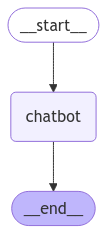

In [6]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
input={"messages":["hi, my name is Parthib"]}

In [8]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is Parthib', additional_kwargs={}, response_metadata={}, id='0362fb19-f203-4a00-87f7-4ad6162c1260'),
  AIMessage(content="Hi Parthib! It's nice to meet you. 👋\n\nIs there anything I can help you with today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 17, 'total_tokens': 45, 'completion_time': 0.050909091, 'prompt_time': 0.001898827, 'queue_time': 0.232850566, 'total_time': 0.052807918}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-752e807b-be6f-4ba5-a277-b4ed014f6300-0', usage_metadata={'input_tokens': 17, 'output_tokens': 28, 'total_tokens': 45})]}

In [9]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [10]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [11]:
search.invoke("Tell me the temperature in India")

"It's 90 degrees and sunny."

In [12]:
tools=[search]

In [13]:
tool_node=ToolNode(tools)

In [14]:
llm_with_tool = llm.bind_tools(tools)

In [15]:

def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [16]:
response=call_model({"messages": ["hi how are you?"]})

In [17]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fxmj', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 941, 'total_tokens': 1022, 'completion_time': 0.147272727, 'prompt_time': 0.080406297, 'queue_time': 0.237967498, 'total_time': 0.227679024}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7126749c-2fe7-466e-bb0d-459fbe3f7552-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': 'call_fxmj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 81, 'total_tokens': 1022})]}

In [18]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [19]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

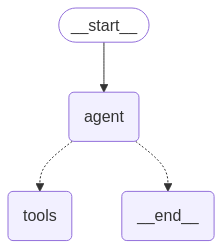

In [20]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='ee908a18-fbee-4182-8478-0def6aae244c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2mrs', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.054217907, 'queue_time': 0.232085166, 'total_time': 0.203308816}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-946408e0-d62c-4539-bafc-fdd22a1a9820-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_2mrs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023}),
  ToolMessage(content="It's 90 degrees and sunny.", name='search', id='dafff150-754c-420a-b0cd-7d8f4dc54a65',

In [22]:
app.invoke({"messages": ["tell me the temperature in sf??"]})

{'messages': [HumanMessage(content='tell me the temperature in sf??', additional_kwargs={}, response_metadata={}, id='b29b6cb9-fb9f-45c9-bbcf-f4e6f57a9648'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tkv9', 'function': {'arguments': '{"query":"temperature in san francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.041112254, 'queue_time': 0.232393693, 'total_time': 0.190203163}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3dd52d5e-dcd5-4c30-bc81-4f741419a2a8-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in san francisco'}, 'id': 'call_tkv9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025}),
  ToolMessage(content="It's 60 degrees and foggy.", name='s

In [24]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [26]:

app = workflow.compile()

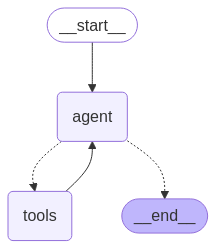

In [28]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bad9', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.032922777, 'queue_time': 0.23775662999999997, 'total_time': 0.182013686}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6cb3a8df-3aae-4efe-b0eb-f4a50feeba09-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_bad9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='024d6352-1baf-47d2-992f-af1380ecf3a5', tool_call_id='call_bad9')]}


here

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [30]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [31]:
app3 = workflow3.compile(checkpointer = memory)

In [32]:
config = {"configurable": {"thread_id": "1"}}

In [33]:
events = app3.stream(
    {"messages": ["Hi there! My name is parthib."]}, config, stream_mode="values"
)

In [34]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is parthib.
================================== Ai Message ==================================
Tool Calls:
  search (call_kfx7)
 Call ID: call_kfx7
  Args:
    query: parthib
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  search (call_8qkb)
 Call ID: call_8qkb
  Args:
    query: parthib weather
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================

That's good to know!


In [35]:
events = app3.stream(
    {"messages": ["Can you please tell me My name?"]}, config, stream_mode="values"
)

In [37]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you please tell me My name?
================================== Ai Message ==================================

parthib


In [38]:
memory.get(config)

{'v': 1,
 'ts': '2025-03-13T07:17:52.345242+00:00',
 'id': '1efffdb4-6db2-6579-8008-004795bdac47',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is parthib.', additional_kwargs={}, response_metadata={}, id='f1bbde4c-4a84-499e-8983-a97067581103'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kfx7', 'function': {'arguments': '{"query":"parthib"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 946, 'total_tokens': 1028, 'completion_time': 0.149090909, 'prompt_time': 0.080832156, 'queue_time': 0.23635677900000002, 'total_time': 0.229923065}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7dd24c1d-ab2d-4446-b0b3-77c514cb70f9-0', tool_calls=[{'name': 'search', 'args': {'query': 'parthib'}, 'id': 'call_kfx7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 82, 